In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets

## Unzip data

In [3]:
import zipfile

train_zip_path = "/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip"
test_zip_path = "/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip"

train_path = "train"
test_path = "test"

with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(train_path)
    
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_path)

## Load data

In [4]:
root = "/kaggle/working/"
train_csv_path = os.path.join(root, train_path, "train.csv")
test_csv_path = os.path.join(root, test_path, "test.csv")

In [5]:
train_df = pd.read_csv(train_csv_path)
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [6]:
test_df = pd.read_csv(test_csv_path)
test_df.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [7]:
labels = train_df.columns[2:].to_numpy()
labels

array(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'], dtype=object)

# Split training dataset into training and validation

Currently we have a training set and a test set. The training set has its corresponding labels, while the test set doesn't.

To make sure that our model doesn't overfit, let's split our training set into two parts: a training set (which will be used to train the model) and a validation set (which will be used to make sure the model doesn't overfit).

In [8]:
train_sentences = train_df["comment_text"]
train_labels = train_df.iloc[:, 2:]

print(f"Train sentences: {train_sentences.shape}")
print(f"Train labels: {train_labels.shape}")

Train sentences: (159571,)
Train labels: (159571, 6)


In [9]:
from sklearn.model_selection import train_test_split

train_pct = 0.8

train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_sentences,
    train_labels,
    train_size=0.8
)

print(f"Train sentences: {train_sentences.shape}")
print(f"Train labels: {train_labels.shape}")
print(f"Validation sentences: {val_sentences.shape}")
print(f"Validation labels: {val_labels.shape}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Train sentences: (127656,)
Train labels: (127656, 6)
Validation sentences: (31915,)
Validation labels: (31915, 6)


# Text Preprocessing

We need to remove some punctuation marks and special charaters, so our text is clean and crisp!

In [10]:
# gunky text, bleugh
train_sentences

67324     Oppose. No valid arguments for a move have bee...
115491    "\nNice suggestion about the evolution article...
140723    Saudi Arabia government and islamofascism\nI s...
66745     ", 8 August 2006 (UTC)\n\nThank you for offici...
144857                  BLARGH BLARGH BLARGH I WILL EAT YOU
                                ...                        
147814                   Bond Argument, will move to bottom
33566     Getting additional opinions does seem like a b...
146799     That's irrelevant.  You're speculating too much.
105089    wikipedia:administrators%27_noticeboard/Wiki_e...
137608    May Lucifer's love be with you, Lift-off. Beep...
Name: comment_text, Length: 127656, dtype: object

In [11]:
import string

def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))

def remove_special_chars(text):
    return text.replace("\n", " ").replace("\t", " ").strip()

def normalize_spacing(text):
    return " ".join(text.split())

def process_text(text):
    text = remove_punctuation(text)
    text = remove_special_chars(text)
    text = normalize_spacing(text)
    return text

In [12]:
# apply preprocessing
train_sentences = train_sentences.map(process_text)
val_sentences = val_sentences.map(process_text)

In [13]:
# before we continue, let's get some info about the word count for the sentences
print("Word count statistics:\n")
train_sentences.apply(len).describe()

Word count statistics:



count    127656.000000
mean        373.749358
std         563.295860
min           3.000000
25%          89.000000
50%         193.000000
75%         413.000000
max        5000.000000
Name: comment_text, dtype: float64

In [14]:
# convert Pandas series to NumPy arrays
train_sentences = train_sentences.to_numpy()
train_labels = train_labels.to_numpy()
val_sentences = val_sentences.to_numpy()
val_labels = val_labels.to_numpy()

In [15]:
# much better!
train_sentences

array(['Oppose No valid arguments for a move have been presented other than WPIDONTLIKEIT There appears to be no need to disambiguate the page either',
       'Nice suggestion about the evolution article jk I think in an article about a controversial topic we should include arguements on both sides of an issue not based on their sillinessvalidity but on their appearance in the debate Please understand that gay marriage is a relatively new concept for many of us I am not opposed to gay marriage I am actually undecided on whether legally using the label marriage for gay marriages is a good idea I am currently leaning towards Marriage privatization although Im leary of anything with privatization in its name I can see why everyone might think that Im some prop 8 troll or something but Im not I was just reading about the topic on here and felt that there were some issues with the article and wanted to contribute',
       'Saudi Arabia government and islamofascism I see that userSlimVirgin 

# Tokenization preparation

**In fact, TensorFlow JS, which is used to load the model on the frontend, does not support the TextVectorization layer. Instead, we'll have to use the TensorFlow Tokenizer.**

In [16]:
# let's figure out how many unique words there are in our vocabulary

vocab = set()
for sentence in train_sentences:
    for word in sentence.split():
        vocab.add(word)
        
vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")

Vocab size: 260604


In [17]:
vocab_size=100000

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_sentences)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [19]:
# get limited vocabulary from tokenizer word index

import json

vocab = {}
for word, index in tokenizer.word_index.items():
    if index <= vocab_size:
        vocab[word] = index
        
print(len(vocab))

with open("tokenizer_dictionary.json", "w") as file:
    json.dump(vocab, file)

100000


In [20]:
# convert sentences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

# pad integer sequences into fixed length
max_length = 300
padding_type = "post"
trunc_type = "post"

train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
val_sequences = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(f"Train sentences (vectorized): {train_sequences.shape}")
print(f"Validation sentences (vectorized): {val_sequences.shape}")

Train sentences (vectorized): (127656, 300)
Validation sentences (vectorized): (31915, 300)


# Create model

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, TextVectorization, Input

In [22]:
# our model will first convert the vectorized sentences into embeddings (fixed-size vectors)
# the model will automatically learn the best embeddings (which are really the weights)
# but we can set the dimension for the embeddings ourselves
embedding_dim = 200

In [23]:
# define and compile model

model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(16, activation="tanh"),
    Dense(6, activation="sigmoid"), # we are predicting for 6 classes
])

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 200)          20000000  
                                                                 
 lstm (LSTM)                 (None, 16)                13888     
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
Total params: 20,013,990
Trainable params: 20,013,990
Non-trainable params: 0
_________________________________________________________________


In [25]:
# set model training parameters

epochs = 5 # if you want to improve performance, try increasing the number of training epochs
batch_size = 64
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
]

In [26]:
model.evaluate(val_sequences, val_labels)

998/998 [==============================] - 11s 7ms/step - loss: 0.6901 - accuracy: 0.9700


[0.6900715231895447, 0.9700140953063965]

In [27]:
# train model

model.fit(
    train_sequences,
    train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
)

Epoch 1/5
1995/1995 [==============================] - 167s 82ms/step - loss: 0.1525 - accuracy: 0.9937 - val_loss: 0.1419 - val_accuracy: 0.9930
Epoch 2/5
1995/1995 [==============================] - 52s 26ms/step - loss: 0.1395 - accuracy: 0.9934 - val_loss: 0.1419 - val_accuracy: 0.9929
Epoch 3/5
1995/1995 [==============================] - 49s 25ms/step - loss: 0.1390 - accuracy: 0.9937 - val_loss: 0.1412 - val_accuracy: 0.9930
Epoch 4/5
1995/1995 [==============================] - 44s 22ms/step - loss: 0.1386 - accuracy: 0.9872 - val_loss: 0.1412 - val_accuracy: 0.9768
Epoch 5/5
1995/1995 [==============================] - 43s 22ms/step - loss: 0.1278 - accuracy: 0.9579 - val_loss: 0.1410 - val_accuracy: 0.9624


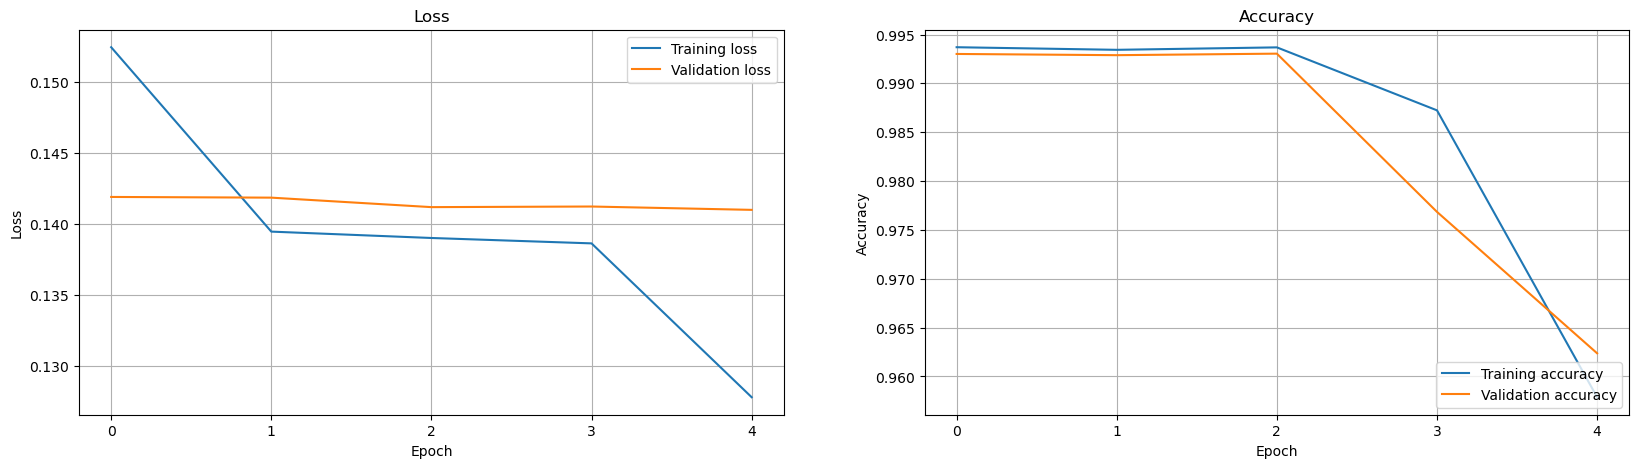

In [28]:
hist = model.history.history

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(hist["loss"], label="Training loss")
plt.plot(hist["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(len(hist["loss"])))
plt.legend(loc="upper right")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(hist["accuracy"], label="Training accuracy")
plt.plot(hist["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(len(hist["accuracy"])))
plt.legend(loc="lower right")
plt.grid(True)

plt.show()

# Predictions

In [29]:
def predict(sentence):
    # convert sentence to sequence
    sequences = tokenizer.texts_to_sequences([sentence])
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    
    # get predictions for toxicity
    predictions = model.predict(padded_sequences)[0]
    
    return list(zip(labels, predictions))

In [30]:
predict("I hate you")

1/1 [==============================] - 0s 385ms/step


[('toxic', 0.093440264),
 ('severe_toxic', 0.007150036),
 ('obscene', 0.04974302),
 ('threat', 0.0017526061),
 ('insult', 0.049061067),
 ('identity_hate', 0.00843494)]

In [31]:
predict("You should kill yourself right now")

1/1 [==============================] - 0s 21ms/step


[('toxic', 0.093440264),
 ('severe_toxic', 0.007150036),
 ('obscene', 0.04974302),
 ('threat', 0.0017526061),
 ('insult', 0.049061067),
 ('identity_hate', 0.00843494)]

In [32]:
predict("I love you")

1/1 [==============================] - 0s 21ms/step


[('toxic', 0.093440264),
 ('severe_toxic', 0.007150036),
 ('obscene', 0.04974302),
 ('threat', 0.0017526061),
 ('insult', 0.049061067),
 ('identity_hate', 0.00843494)]

# Export model

In [33]:
loss, accuracy = model.evaluate(val_sequences, val_labels)
print(f"Accuracy on validation sentences: {accuracy}")

998/998 [==============================] - 6s 6ms/step - loss: 0.1410 - accuracy: 0.9624
Accuracy on validation sentences: 0.9623687863349915


In [34]:
# save model

save_dir = "comment_toxicity_classifier.h5"
model.save(save_dir)